In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
import warnings

warnings.filterwarnings('ignore')

# Rolling Avg

In [2]:
# Link: https://baseballsavant.mlb.com/statcast_search?hfPT=FF%7C&hfAB=&hfGT=R%7C&hfPR=&hfZ=&hfStadium=&hfBBL=&hfNewZones=&hfPull=&hfC=&hfSea=2023%7C2022%7C2021%7C&hfSit=&player_type=pitcher&hfOuts=&hfOpponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt=&game_date_lt=&hfMo=&hfTeam=&home_road=&hfRO=&position=&hfInfield=&hfOutfield=&hfInn=&hfBBT=&hfFlag=&pitchers_lookup%5B%5D=608337&metric_1=&group_by=name&min_pitches=0&min_results=0&min_pas=0&sort_col=pitches&player_event_sort=api_p_release_speed&sort_order=desc&chk_stats_spin_rate=on#results
fb_stcst = pd.read_csv('Data/fastball_data.csv', low_memory=True).sort_values('game_date')
fb_stcst['year'] = fb_stcst.game_date.str[0:4]

# Add year variable to sort by year
fb_stcst_21 = fb_stcst[fb_stcst['year'] == '2021']
fb_stcst_22 = fb_stcst[fb_stcst['year'] == '2022']
fb_stcst_23 = fb_stcst[fb_stcst['year'] == '2023']

In [3]:
# Calculate average fastball spin rate for each start
game21_avg_spin = fb_stcst_21.groupby('game_date').agg('release_spin_rate').mean().reset_index()
game22_avg_spin = fb_stcst_22.groupby('game_date').agg('release_spin_rate').mean().reset_index()
game23_avg_spin = fb_stcst_23.groupby('game_date').agg('release_spin_rate').mean().reset_index()

# Reformat date variable for readability
#game21_avg_spin['game_date'] = pd.to_datetime(game21_avg_spin['game_date']).dt.strftime('%m/%d/%Y')
#game22_avg_spin['game_date'] = pd.to_datetime(game22_avg_spin['game_date']).dt.strftime('%m/%d/%Y')
#game23_avg_spin['game_date'] = pd.to_datetime(game23_avg_spin['game_date']).dt.strftime('%m/%d/%Y')

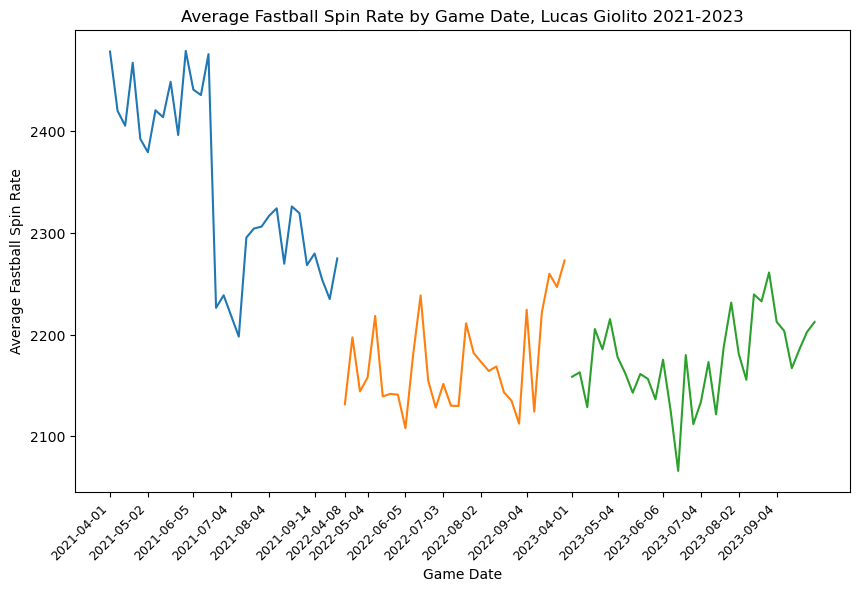

In [4]:
game_spin_rates = pd.concat([game21_avg_spin, game22_avg_spin, game23_avg_spin])
game_spin_rates['year'] = game_spin_rates.game_date.str[0:4]

# Create a figure and axis
fig, ax = plt.subplots(figsize = (10,6))

# Iterate through the years and plot data for each year
years = game_spin_rates.year.unique()
for year in years:
    year_data = game_spin_rates[game_spin_rates.year == year]
    ax.plot(year_data.game_date, year_data['release_spin_rate'])

# Customize the plot
ax.set_xlabel('Game Date')
ax.set_ylabel('Average Fastball Spin Rate')
ax.set_title('Average Fastball Spin Rate by Game Date, Lucas Giolito 2021-2023')

months = ['2021-04-01','2021-05-02','2021-06-05','2021-07-04','2021-08-04','2021-09-14',
'2022-04-08','2022-05-04','2022-06-05','2022-07-03','2022-08-02','2022-09-04',
'2023-04-01','2023-05-04','2023-06-06','2023-07-04','2023-08-02','2023-09-04']
ax.set_xticks(months)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, 
                        horizontalalignment='right', fontdict = {'size':9})
plt.show()

# Nearest Neighbors

In [5]:
pitch_mvt = pd.read_csv("Data/mvt_data.csv")
pitch_mvt['ff_avg_IVB'] = round((523/pitch_mvt.ff_avg_speed)**2 + pitch_mvt.ff_avg_break_z,1)
pitch_mvt['ch_avg_IVB'] = round((523/pitch_mvt.ch_avg_speed)**2 + pitch_mvt.ch_avg_break_z,1)
pitch_mvt['sl_avg_IVB'] = round((523/pitch_mvt.sl_avg_speed)**2 + pitch_mvt.sl_avg_break_z,1)
pitch_mvt = pitch_mvt.rename(columns={'last_name, first_name': 'player_name'})

In [6]:
def similar_pitches(pitch_data, name, id_cols, feat_cols):
    # Return pitch data filtered for player of interest and features of interest
    plyr_pitches = pitch_data[pitch_data.player_name == name][id_cols + feat_cols].sort_values('year', ascending=True)

    # Separate all other pitcher data
    pitches = pitch_data[~(pitch_data.player_name == name)]
    
    # Filter for features of interest and drop NA values
    pitches = pitches[id_cols + feat_cols].dropna().reset_index(drop=True)
    
    # Filter all players to index on for similar pitches
    all_players = pitches[id_cols].reset_index(drop=True)
    pitches = pitches[feat_cols]
    
    # Instantiate nearest-neighbors search algorithm, set for 3 nearest neighbors
    nearest_neigh = NearestNeighbors(n_neighbors=3)
    nearest_neigh.fit(pitches)
    
    name = name.split(', ')[1] + ' ' + name.split(', ')[0]
    
    for index, row in plyr_pitches.iterrows():
        print(name + ' ' + str(row.year) +', Most Similar:')
        print('-----------------------------------------------------------')
        
        # For each row, find nearest neighbors index/distance
        row = np.array(row.drop(id_cols)).reshape(1,-1)
        nearest_neighors  = nearest_neigh.kneighbors(row)
        
        # With list of indices for nearest neighbors, find name and year of pitcher with similar pitch
        n_neigh_index = nearest_neighors[1][0]
        simi_pitchers = [str(all_players.loc[i].year) + ' ' + all_players.loc[i].player_name for i in n_neigh_index]
        print(simi_pitchers,'\n')


## Fastballs

In [7]:
fb_data = pd.read_csv("Data/FB_21_23.csv")
fb_data = fb_data.merge(pitch_mvt, how = 'left', on = ['player_name','year','player_id'])

id_cols = ['player_id','player_name','year']

fb_feat_cols = ['spin_rate', 'velocity', 'effective_speed', 'eff_min_vel', 'release_extension', 'ff_avg_speed', 
             'ff_avg_break_x', 'ff_avg_break_z', 'ff_avg_IVB']

In [8]:
similar_pitches(fb_data, 'Giolito, Lucas', id_cols, fb_feat_cols)

Lucas Giolito 2021, Most Similar:
-----------------------------------------------------------
['2023 Pepiot, Ryan', '2023 Pivetta, Nick', '2021 Bickford, Phil'] 

Lucas Giolito 2022, Most Similar:
-----------------------------------------------------------
['2023 Sweet, Devin', '2022 Archer, Chris', '2023 Daniel, Davis'] 

Lucas Giolito 2023, Most Similar:
-----------------------------------------------------------
['2022 Archer, Chris', '2023 Sweet, Devin', '2022 Head, Louis'] 



## Changeups

In [9]:
ch_data = pd.read_csv("Data/CH_21_23.csv")
ch_data = ch_data.merge(pitch_mvt, how = 'left', on = ['player_name','year','player_id'])



id_cols = ['player_id','player_name','year']

ch_feat_cols = ['spin_rate', 'velocity', 'effective_speed', 'eff_min_vel', 'release_extension', 'ch_avg_speed', 
             'ch_avg_break_x', 'ch_avg_break_z', 'ch_avg_IVB']

In [10]:
similar_pitches(ch_data, 'Giolito, Lucas', id_cols, ch_feat_cols)

Lucas Giolito 2021, Most Similar:
-----------------------------------------------------------
['2021 Alexy, A.J.', '2021 Megill, Tylor', '2021 Sanchez, Aaron'] 

Lucas Giolito 2022, Most Similar:
-----------------------------------------------------------
['2022 Thornburg, Tyler', '2021 Scherzer, Max', '2023 Fulmer, Carson'] 

Lucas Giolito 2023, Most Similar:
-----------------------------------------------------------
['2021 Bundy, Dylan', '2022 Devenski, Chris', '2022 Goudeau, Ashton'] 



## Sliders

In [11]:
sl_data = pd.read_csv("Data/SL_21_23.csv")
sl_data = sl_data.merge(pitch_mvt, how = 'left', on = ['player_name','year','player_id'])



id_cols = ['player_id','player_name','year']

sl_feat_cols = ['spin_rate', 'velocity', 'effective_speed', 'eff_min_vel', 'release_extension', 'ch_avg_speed', 
             'ch_avg_break_x', 'ch_avg_break_z', 'sl_avg_IVB']

In [12]:
similar_pitches(sl_data, 'Giolito, Lucas', id_cols, sl_feat_cols)

Lucas Giolito 2021, Most Similar:
-----------------------------------------------------------
['2021 Plesac, Zach', '2022 Gray, Josiah', '2022 Manaea, Sean'] 

Lucas Giolito 2022, Most Similar:
-----------------------------------------------------------
['2021 Pineda, Michael', '2023 Gore, MacKenzie', '2023 Moreta, Dauri'] 

Lucas Giolito 2023, Most Similar:
-----------------------------------------------------------
['2023 Moreta, Dauri', '2023 Lively, Ben', '2021 Pineda, Michael'] 



# Stuff+ Rankings, by Year

In [13]:
stf_preban = pd.read_csv('Data/stf+_preban.csv', low_memory=False)
stf_postban = pd.read_csv('Data/stf+_postban.csv',low_memory=False)
stf_22_23 = pd.read_csv('Data/stf+_2223.csv',low_memory=False)

stf_id_cols = ['Name','Team']

In [14]:
def rank_stf(data, col, ids = stf_id_cols):
    data = data[data[col].notna()][ids + [col]].sort_values(col, ascending = False)
    data['rank'] = data[col].rank(ascending=False)
    return data

In [15]:
fb_ranks_preban = rank_stf(stf_preban, 'Stf+ FA')
fb_ranks_preban[fb_ranks_preban.Name == 'Lucas Giolito']

,Name,Team,Stf+ FA,rank
20,Lucas Giolito,CHW,116.953971,21.0


In [16]:
fb_ranks_postban = rank_stf(stf_postban, 'Stf+ FA')
fb_ranks_postban[fb_ranks_postban.Name == 'Lucas Giolito']

,Name,Team,Stf+ FA,rank
19,Lucas Giolito,CHW,103.742647,20.0


In [17]:
stf_22 = stf_22_23[stf_22_23.Season == 2022]
stf_23 = stf_22_23[stf_22_23.Season == 2023]

fb_ranks_22 = rank_stf(stf_22, 'Stf+ FA')
fb_ranks_23 = rank_stf(stf_23, 'Stf+ FA')

fb_ranks_22[fb_ranks_22.Name == 'Lucas Giolito']

,Name,Team,Stf+ FA,rank
69,Lucas Giolito,CHW,85.232292,79.0


In [18]:
fb_ranks_23[fb_ranks_23.Name == 'Lucas Giolito']

,Name,Team,Stf+ FA,rank
36,Lucas Giolito,- - -,83.731166,77.0


# Other

In [19]:
fb_changes = fb_data[id_cols + fb_feat_cols].sort_values(['player_name','year'])
fb_changes['FB_IVB_change'] = fb_changes.groupby(['player_id','player_name'])['ff_avg_IVB'].diff()
fb_changes['FB_HB_change'] = fb_changes.groupby(['player_id','player_name'])['ff_avg_break_x'].diff()

fb_changes = fb_changes.dropna().sort_values('FB_IVB_change')

<Axes: xlabel='FB_IVB_change', ylabel='Count'>

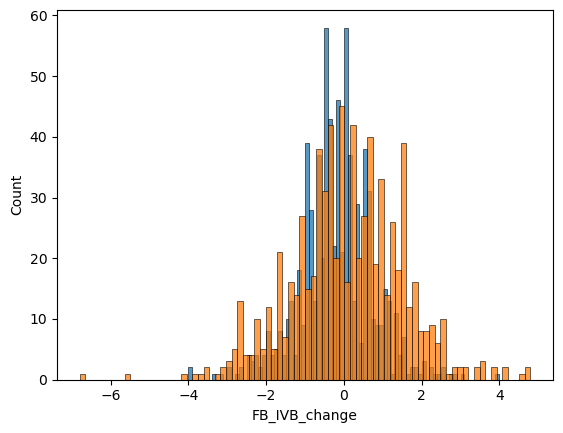

In [20]:
sns.histplot(fb_changes.FB_IVB_change,bins=80)
sns.histplot(fb_changes.FB_HB_change,bins=80)